In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
%matplotlib inline

In [2]:
df = pd.read_csv("immune related genes.csv")
immune_genes = set(df["Gene Name"].values)
df = pd.read_csv("data/exp.gene.mRNA.GSE57065.csv",index_col=0)
plat1= set(df.index.values)
df = pd.read_csv("data/exp.gene.mRNA.GSE65682.csv",index_col=0)
plat2= set(df.index.values)
df = pd.read_csv("data/exp.gene.mRNA.GSE1548.csv",index_col=0)
plat3=set(df.index.values)

immune_genes = immune_genes & plat1 & plat2 & plat3

In [3]:
Y = np.array(pd.read_csv("label/label_GSE57065.csv",index_col=0))
data =  pd.read_csv("data/exp.gene.mRNA.GSE57065.csv",index_col=0).loc[immune_genes]
X=np.array(data).T
ind = np.array(range(X.shape[1]))
C = 0.83
while 1:
    model_logit = LogisticRegression(solver='liblinear')
    results2 = model_logit.fit(X,Y.ravel())
    coef = results2.coef_.flatten()
    removed = np.argwhere(np.abs(coef)<(C*np.sum(np.abs(coef))/coef.shape[0])).flatten()
    if removed.shape[0]==0:
        break
    else:
        ind=np.delete(ind,removed,axis=0)
        X=np.delete(X,removed,axis=1)
markers2 = data.iloc[ind].index

In [4]:
Y = np.array(pd.read_csv("label/label_GSE57065.csv",index_col=0))
data =  pd.read_csv("data/exp.gene.mRNA.GSE57065.csv",index_col=0).loc[immune_genes]
X=np.array(data).T

model_logit = LogisticRegression(solver = 'liblinear',penalty="l1")
results = model_logit.fit(X,Y.ravel())
coef = results.coef_.flatten()
ind = np.argsort(np.abs(coef))[-5:]
markers = data.iloc[ind,:].index.values.tolist()
X = np.array(data.loc[immune_genes].loc[markers]).T
results = model_logit.fit(X,Y.ravel())

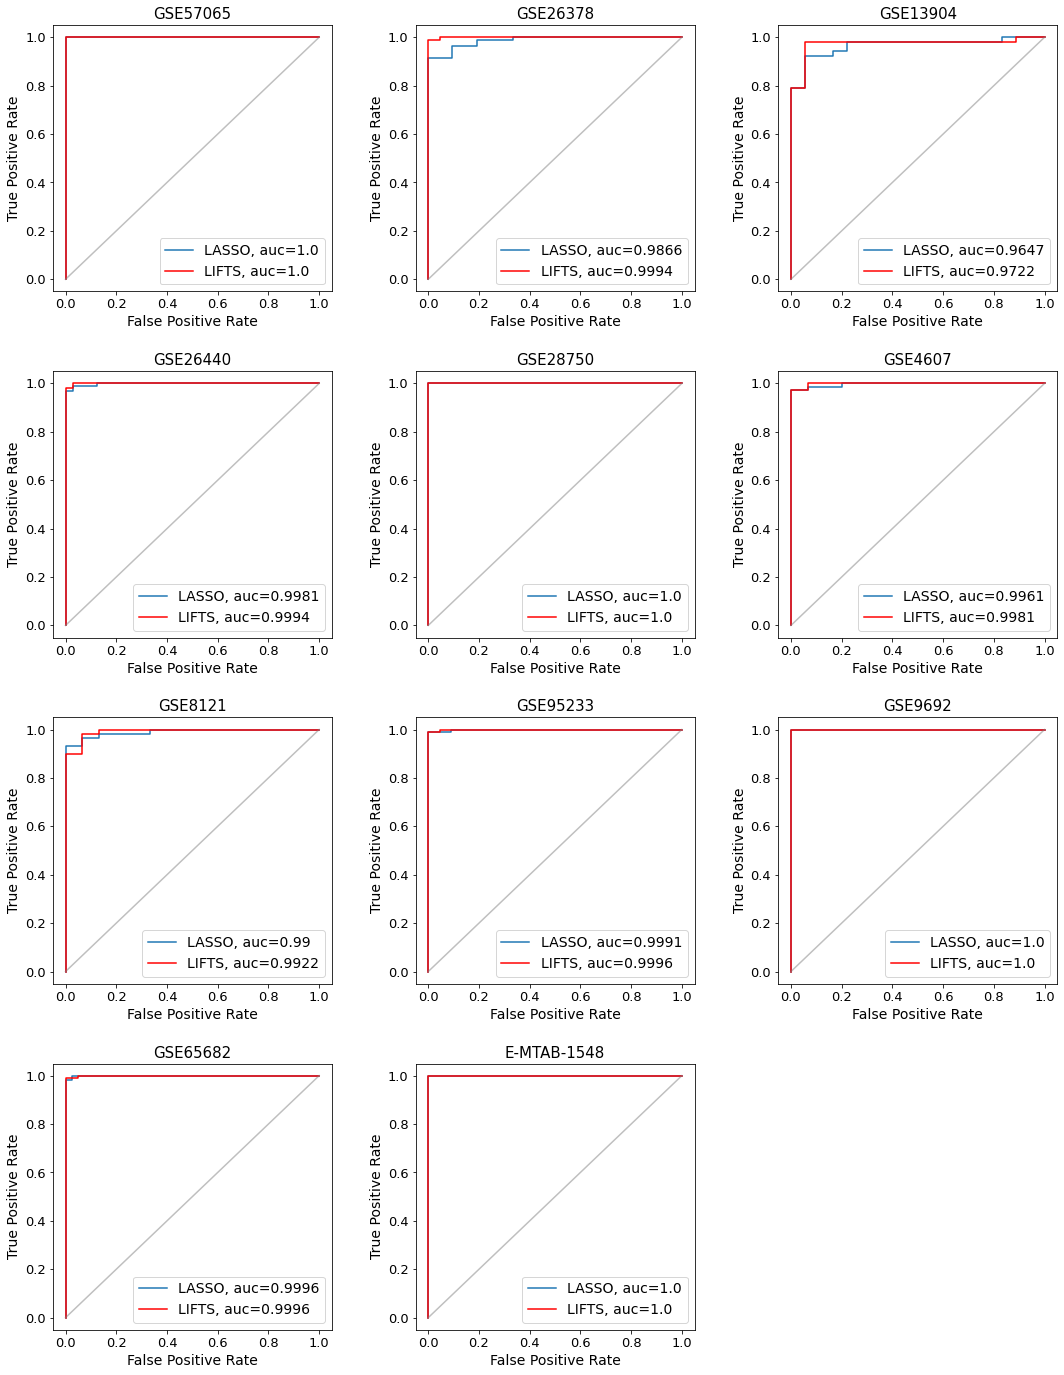

In [5]:
fig = plt.figure(figsize=(18,24))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
WIDTH =None
FONTSIZE = 15
for index,data_set in enumerate(['57065','26378','13904','26440','28750','4607',
                            '8121','95233','9692','65682','1548']):
    fig.add_subplot(4,3,index+1)
    y = np.array(pd.read_csv("label/label_GSE"+data_set+".csv",index_col=0))
    valid = np.where(y<2)[0].tolist()
    y = y[valid]
    df = pd.read_csv("data/exp.gene.mRNA.GSE"+data_set+".csv",index_col=0)
    df = df.iloc[:,valid]
    
    X = np.array(df.loc[immune_genes].loc[markers]).T
    y_pred_proba = results.predict_proba(X)[:,1]
    auc = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    plt.plot(fpr,tpr,label="LASSO, auc="+str(round(auc,4)),linewidth=WIDTH)
    
    X = np.array(df.loc[immune_genes].loc[markers2]).T
    y_pred_proba = results2.predict_proba(X)[:,1]
    auc = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    plt.plot(fpr,tpr,label="LIFTS, auc="+str(round(auc,4)),c='r',linewidth=WIDTH)
    
    if data_set != '1548':
        plt.title('GSE'+data_set,fontsize=FONTSIZE)
    else:
        plt.title('E-MTAB-1548',fontsize=FONTSIZE)
    plt.legend(loc='best',fontsize=FONTSIZE-1)
    plt.xticks(fontsize=FONTSIZE-2)
    plt.yticks(fontsize=FONTSIZE-2)
    plt.ylabel('True Positive Rate',fontsize=FONTSIZE-1)
    plt.xlabel('False Positive Rate',fontsize=FONTSIZE-1)
    plt.plot([0,1],[0,1],color='gray',alpha=0.5)
plt.savefig("figure/AUC.pdf", bbox_inches='tight')